## Contents
* [1. Introduction](#first-bullet)
* [2. Filtering ](#second-bullet)
* [3. Wrapping ](#third-bullet)
* [4 Storing the variables](#fourth-bullet)

## Introduction <a class="anchor" id="first-bullet"></a>
This notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable file names can be changed.

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

During filtering, if balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

For wrapping forward selection method has been used where the scoring function is fdr. Finally, we choose the top variables and output the dataset with these features into a csv.


In [1]:
# load libraries
# %pip install mlxtend
# %pip install lightgbm

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [96]:
# set some parameters
fileList = ['final1_1.csv','final2_2.csv','final3_3.csv'] #names of the files which can be changed here
num_files = len(fileList)
num_filter = 30 #from each file how many top variables should be filtered
tot_filter = num_filter*num_files #not used
num_wrapper = 20 #how many variables should be selected by the wrapper
balance = 0 #if we want to downsample the goods for feature selection
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## Filtering <a class="anchor" id="second-bullet"></a>

This part of the code reads all the individual files and applies KS filtering on it. 
Top num_filter variables from each file are found and wrapping is performed on num_filter * num_files variables.
For example if there are 3 vars files then for each file 50 are selected and finally, 150 variables are input to the wrapper.

In [67]:
#last two months index
df_i = pd.read_csv("card transactions.csv")
oot_index = min(df_i[df_i['Date']>='2006-11-01'].Recnum)
#first two weeks index
i_weeks_index = min(df_i[df_i['Date']>='2006-01-14'].Recnum)
del df_i

For each loop we do the following:
- Read the file; remove OOT data and first two weeks data
- create a variable with random values in it. This is just to perform a sanity check 
- If balance is not equal to 0, downsample the goods. We have to keep the samples the same for all the files.
- For each column, apply KS scoring and store the KS value in filter_score against that variable's name
- Find the top num_filter variables and create a dataframe to only contain those variables and Y variable containing the fraud label variable


In [68]:
%%time
filter_score_df_list = []
for i,file_name in enumerate(fileList):
#     file_name = "vars"+str(i+1)+'.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= oot_index] # remove the last two months as the out-of-time data (OOT)  #84300
    df = df[df.index >= i_weeks_index] # remove the first 2 weeks of records since their variables aren't well formed #2995
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
    
    """
    Not that it matters a lot but I usually put the dataframes in a list and concatenate them after coming out of loop.
    Someone at my previous organization said that it was more efficient but I did not check the efficiency benefit myself.
    """
#     filter_score = pd.concat([filter_score,new])
    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on final1_1.csv size is (96397, 152)
100
final1_1.csv                            variable     score
92                            Fraud  1.000000
16              Cardnum_Zip_total_7  0.684885
127    Cardnum_Merchnum_zip_total_7  0.678691
149             Cardnum_Zip_total_3  0.677626
54    Cardnum_Merchnum_zip3_total_7  0.671999
104           Cardnum_state_total_7  0.669686
6    Cardnum_Merchnum_zip3_total_14  0.665531
23              Cardnum_Zip_total_1  0.660539
65               Cardnum_Zip_max_14  0.655663
150         Cardnum_Merchnum_max_14  0.654567
22             Cardnum_Zip3_total_1  0.653927
73      Cardnum_Merchnum_zip_max_14  0.651473
3     Cardnum_Merchnum_state_max_30  0.650915
113             Cardnum_Zip3_max_14  0.649856
55   Cardnum_Merchnum_zip3_total_30  0.649589
110      Cardnum_Merchnum_zip_max_7  0.647455
76     Cardnum_Merchnum_zip3_max_30  0.642572
58       Cardnum_Merchnum_zip_max_3  0.641552
19      Cardnum_Merchnum_zip3_max_3  0.635892
126    

In [69]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [70]:
# filter_score[filter_score['variable']=='Merchnum_Zip_total_3']

In [71]:
filter_score.head(100)

,variable,score
92,Fraud,1.000000
398,Fraud,1.000000
214,Fraud,1.000000
16,Cardnum_Zip_total_7,0.684885
111,Cardnum_Merchnum_state_total_7,0.681567
...,...,...
2,Merchnum_Zip3_max_0,0.595544
146,Cardnum_Merchnum_zip3_max_0,0.594525
171,Merchnum_total_1,0.594367
78,Cardnum_Merchnum_state_avg_30,0.593361


In [72]:
filter_score.shape

(768, 2)

In [73]:
num_filter+3

53

In [11]:
# filter_score.sort_values(by=['score'], ascending=False, inplace=True)
# vars_keep = list(filter_score['variable'][num_files:tot_filter+3])
# print(i,' vars_keep:',vars_keep)

In [74]:
df_keep = df_top.copy() #since in the loop we filter the top num_filter variables from each file and store them in df_top, we can use that dataframe 


In [75]:
# vars_keep_df = pd.DataFrame({'col':vars_keep})
# vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
# df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,Cardnum_Zip_total_7,Cardnum_Merchnum_zip_total_7,Cardnum_Zip_total_3,Cardnum_Merchnum_zip3_total_7,Cardnum_state_total_7,Cardnum_Merchnum_zip3_total_14,Cardnum_Zip_total_1,Cardnum_Zip_max_14,Cardnum_Merchnum_max_14,Cardnum_Zip3_total_1,...,Merchnum_Zip3_med_1,Merchnum_Zip_med_1,Merchnum_max_14,Merchnum_Zip3_max_14,Merchnum_med_1,Merchnum_Zip3_avg_14,Merchnum_Zip_med_3,Merchnum_Zip3_med_3,Merchnum_Zip_avg_14,Merchnum_med_3
Recnum,,,,,,,,,,,,,,,,,,,,,
2995,1023.04,1023.04,174.20,1023.04,1023.04,1023.04,174.20,792.26,792.26,174.20,...,174.20,174.20,2454.99,2454.99,174.20,262.471081,76.825,76.825,262.471081,76.825
2996,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,...,250.00,250.00,250.00,250.00,250.00,176.666667,250.000,250.000,176.666667,250.000
2997,76.85,76.85,76.85,53.88,76.85,53.88,53.88,53.88,53.88,53.88,...,46.95,40.02,1097.60,999.90,40.02,326.450000,46.950,53.880,241.561765,46.950
2998,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,...,80.70,80.70,4666.00,4666.00,80.70,921.682759,152.900,152.900,921.682759,152.900
2999,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,...,299.78,299.78,756.08,756.08,299.78,445.100000,377.990,377.990,445.100000,377.990


In [76]:
df_keep.shape

(80983, 150)

In [77]:
Y.head()

,Fraud
Recnum,
2995,0
2996,0
2997,0
2998,0
2999,0


In [78]:
Y = Y.values
Y_save = Y.copy()

In [79]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [80]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 16:22:28.963270


In [81]:
print(X.shape,Y.shape)

(80983, 150) (80983, 1)


In [82]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


## Wrapping <a class="anchor" id="third-bullet"></a>

In [83]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [84]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=30,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=10,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.5min finished

[2022-06-01 23:31:48] Features: 1/20 -- score: 0.6186848436246992[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:  1.6min finished

[2022-06-01 23:33:24] Features: 2/20 -- score: 0.6475942261427426[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:  1.8min finished

[2022-06-01 23:35:10] Features: 3/20 -- score: 0.6614942528735632[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 147 out o

Wall time: 58min 52s



[2022-06-02 00:29:12] Features: 20/20 -- score: 0.7053461641272387

SequentialFeatureSelector(cv=10,
                          estimator=LGBMClassifier(n_estimators=30,
                                                   num_leaves=3),
                          k_features=20, n_jobs=-1,
                          scoring=<function fdr at 0x00000274A2DFF3A0>,
                          verbose=2)

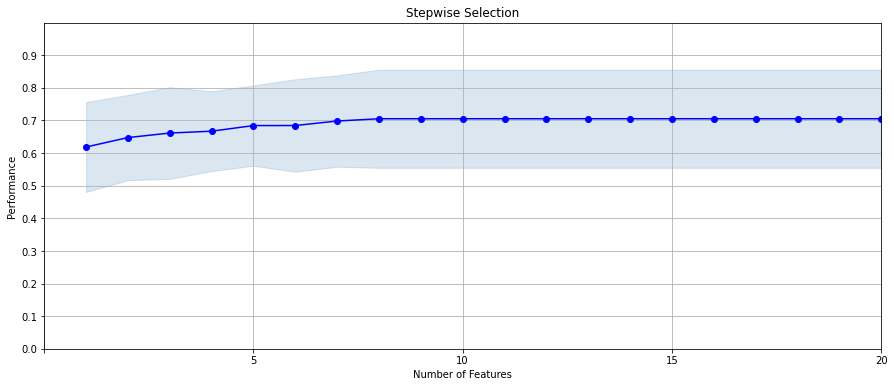

In [85]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

## Storing the variables <a class="anchor" id="fourth-bullet"></a>

In [86]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [87]:
vars_FS.columns

Index(['feature_idx', 'cv_scores', 'avg_score', 'feature_names', 'ci_bound',
       'std_dev', 'std_err'],
      dtype='object')

In [88]:
vars_FS['Previous Features'] = vars_FS.feature_names.shift().fillna('')

In [89]:
vars_FS['New Feature'] = vars_FS.apply(lambda x : list(set(x['feature_names']) - set(x['Previous Features']))[0], axis = 1) 

In [90]:
vars_final = [i for i in vars_FS['New Feature']]

In [35]:
# ordered_vars_FS = vars_FS.copy()
# for i in range(len(ordered_vars_FS)):
#     ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
#     if i+1 == 1:
#         ordered_vars_FS.loc[i+1,'variable name'] = list(ordered_vars_FS.loc[i+1,'feature_names'])[0]
#     else:
#         ordered_vars_FS.loc[i+1,'variable name'] = set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])

In [ ]:
# ['Cardnum_Merchnum_total_7',
#  'Cardnum_state_max_14',
#  'Merchnum_Zip3_max_14',
#  'Cardnum_Merchnum_total_14',
#  'Cardnum_Merchnum_state_total_7',
#  'Merchnum_med_3',
#  'Cardnum_Merchnum_zip_total_30',
#  'Cardnum_Merchnum_zip3_total_7',
#  'Merchnum_med_0',
#  'Merchnum_Zip_med_1',
#  'Merchnum_Zip_med_0',
#  'Merchnum_Zip3_med_1',
#  'Merchnum_med_1',
#  'Merchnum_Zip3_med_3',
#  'Merchnum_Zip_med_3',
#  'Cardnum_Merchnum_total_30',
#  'Cardnum_Merchnum_state_total_30',
#  'Cardnum_Merchnum_zip3_total_14',
#  'Cardnum_Merchnum_zip_total_14',
#  'Cardnum_Merchnum_state_total_14']

In [91]:
vars_final

['Cardnum_Merchnum_zip_total_7',
 'Cardnum_state_max_3',
 'Merchnum_Zip3_avg_14',
 'Merchnum_Zip3_max_14',
 'Cardnum_Merchnum_zip_med_30',
 'Cardnum_Zip_max_3',
 'Cardnum_Merchnum_zip3_total_30',
 'Cardnum_Merchnum_zip3_max_14',
 'Cardnum_Merchnum_state_avg_1',
 'Cardnum_Merchnum_zip3_avg_0',
 'Cardnum_Zip_avg_0',
 'Cardnum_Merchnum_zip_avg_0',
 'Cardnum_Merchnum_zip3_med_1',
 'Cardnum_Zip3_med_30',
 'Cardnum_Merchnum_med_0',
 'Cardnum_Merchnum_state_med_0',
 'Cardnum_Zip_med_0',
 'Cardnum_Zip_med_30',
 'Cardnum_Zip3_max_3',
 'Merchnum_Zip3_med_0']

In [92]:
# vars_keep = ordered_vars_FS['variable name']
# vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_FS.filter(['New Feature','avg_score']).to_excel('final_vars_list.xlsx')

In [ ]:
# vars_keep_list.append(index_name)
# vars_keep_list.append(y_name)
# vars_keep_list

In [ ]:
# final1.columns

In [93]:
#reading the original variable files to have the final dataframe that would be input to the model algos. We cannot use df_keep created before because that could be downsampled if balance!=0 and it does not have oot data. 
final_df_l = []
for i in fileList:
    if i==fileList[0]:
        final_df = pd.read_csv(i).filter(vars_final + [y_name,index_name])
    else:
        final_df = pd.read_csv(i).filter(vars_final)
    final_df_l.append(final_df)
df_keep = pd.concat(final_df_l,axis = 1)

In [94]:
# df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(96397, 22)


In [95]:
df_keep.to_csv('vars_final.csv',index=False)